In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
import os
import dlib

2024-07-09 00:56:12.901883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 00:56:13.061776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-07-09 00:56:13.061805: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-09 00:56:13.626419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: lib

In [2]:
def align_face(image):
    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor('./pretrained_models/shape_predictor_5_face_landmarks.dat')
    
    detections = detector(img, 0)
    faces = dlib.full_object_detections()
    for detection in detections:
        faces.append(shape_predictor(img, detection))
    
    chip_details = dlib.get_face_chip_details(faces)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(image_center, np.rad2deg(chip_details[0].angle), 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    return rotated_image

In [3]:
raw_path = './data/raw'

In [4]:
name = 'Abdullah al-Attiyah'
number = 1
name_formatted = '_'.join(name.split()) + f'_{number:04d}.jpg'

In [5]:
name_formatted

'Abdullah_al-Attiyah_0001.jpg'

In [6]:
if os.path.exists(os.path.join(raw_path, 'test', name_formatted)):
    image_dir = 'test'
else:
    image_dir = 'train'

img_path = os.path.join(raw_path, image_dir, name_formatted)

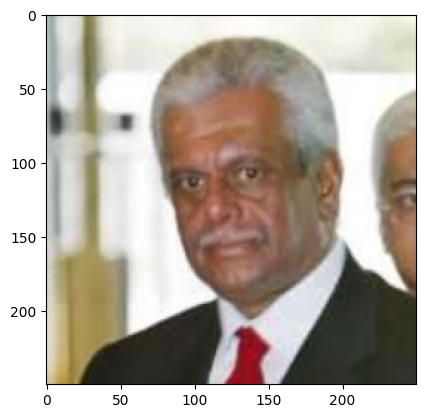

In [7]:
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1]);

In [8]:
rotated_img = align_face(img)

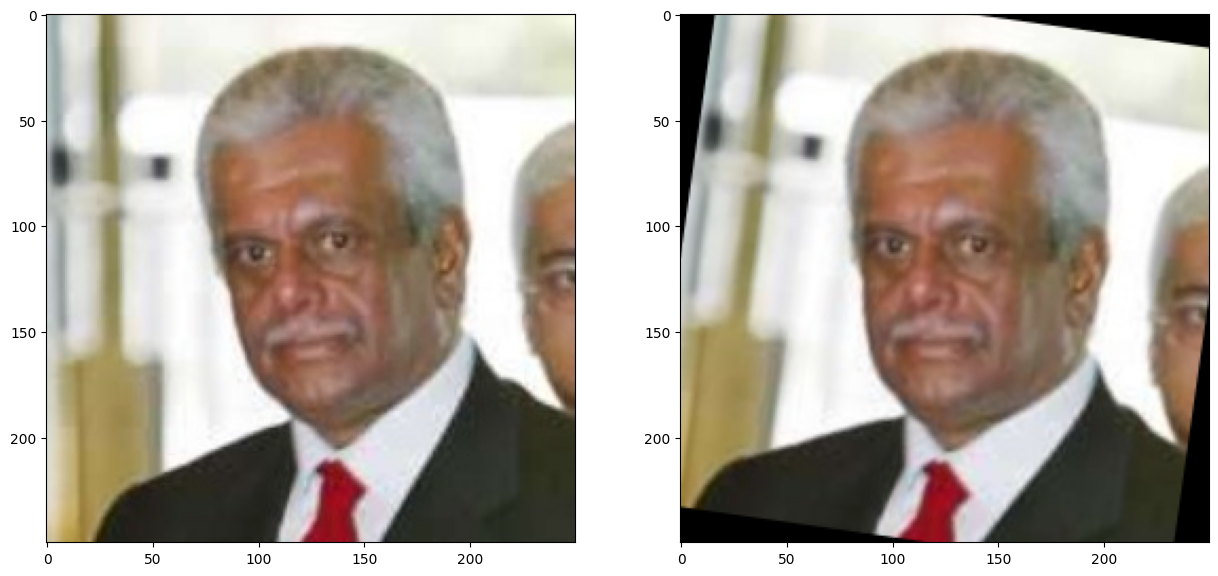

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].imshow(img[:,:,::-1]);
ax[1].imshow(rotated_img[:,:,::-1]);

In [24]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
    # Extract the face blendshapes category names and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

        ax.set_xlabel('Score')
        ax.set_title("Face Blendshapes")
        plt.tight_layout()
        plt.show()

libEGL warning: DRI2: failed to authenticate
I0000 00:00:1720468029.166433    1990 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720468029.171259    2970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720468029.173478    1990 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


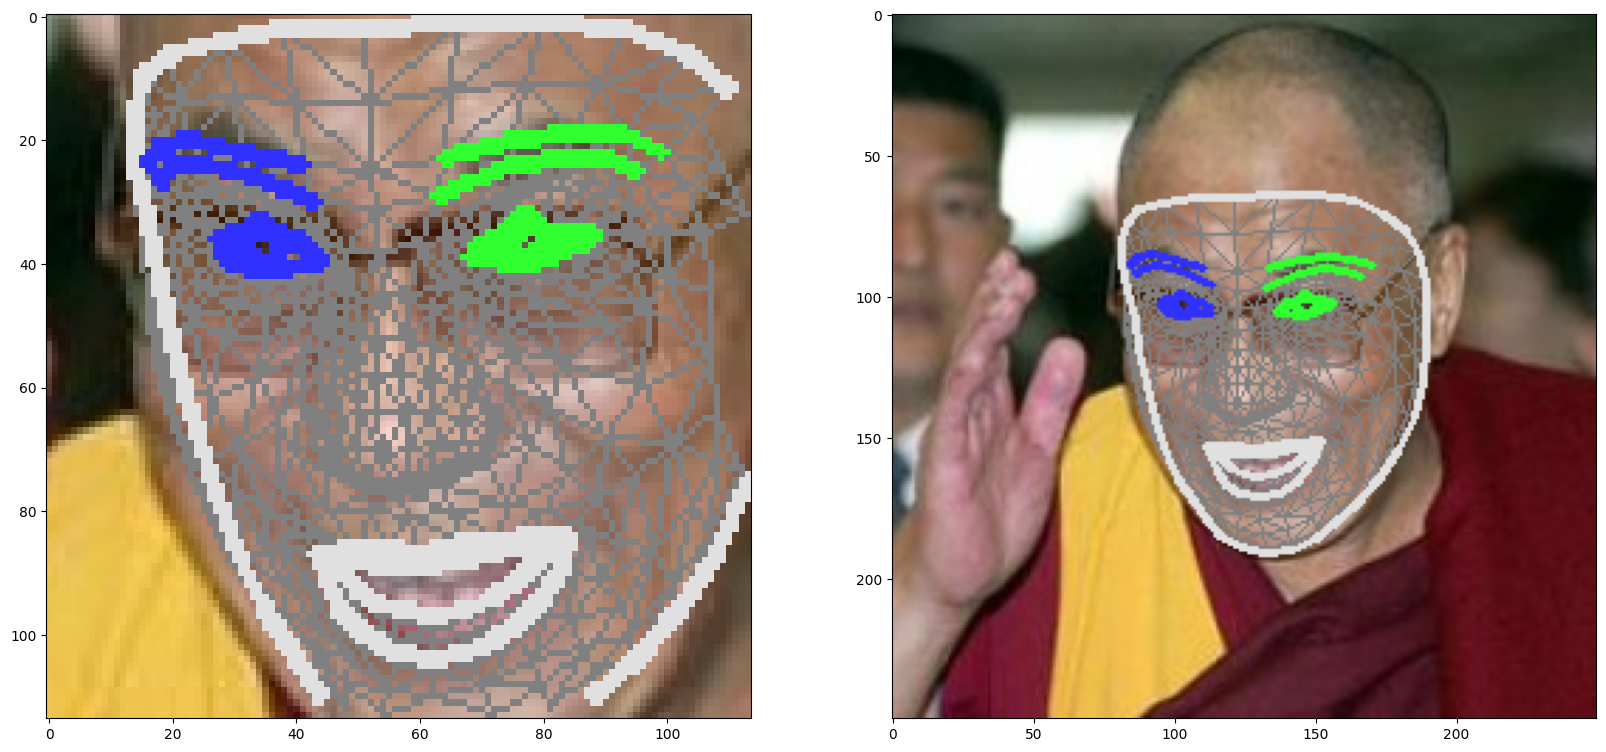

In [25]:
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path = './pretrained_models/face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options = base_options,
                                       output_face_blendshapes = True,
                                       output_facial_transformation_matrixes = True,
                                       num_faces = 1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image_red = mp.Image(image_format = mp.ImageFormat.SRGB, data = img_red)
image = mp.Image(image_format = mp.ImageFormat.SRGB, data = img)

# STEP 4: Detect face landmarks from the input image.
detection_result_red = detector.detect(image_red)
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image_red = draw_landmarks_on_image(image_red.numpy_view(), detection_result_red)
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(annotated_image_red)
ax[1].imshow(annotated_image)

In [26]:
[x for x in dir(detection_result) if '__' not in x]

['face_blendshapes', 'face_landmarks', 'facial_transformation_matrixes']

In [27]:
detection_result.face_landmarks[0]

[NormalizedLandmark(x=0.5125995874404907, y=0.6189215183258057, z=-0.018191823735833168, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4927475154399872, y=0.5732542276382446, z=-0.08678418397903442, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5023344159126282, y=0.5813961625099182, z=-0.03529052063822746, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4756767153739929, y=0.5020506978034973, z=-0.0817999467253685, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4902728497982025, y=0.5553503036499023, z=-0.09836309403181076, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.48953065276145935, y=0.5265441536903381, z=-0.09940553456544876, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4915100336074829, y=0.44915562868118286, z=-0.07796935737133026, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.38787949085235596, y=0.4194033443927765, z=0.010166830383241177, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4900820553302765, y=0

In [28]:
detection_result.face_blendshapes[0]

[Category(index=0, score=2.1182329419389134e-06, display_name='', category_name='_neutral'),
 Category(index=1, score=0.009684945456683636, display_name='', category_name='browDownLeft'),
 Category(index=2, score=0.00225938786752522, display_name='', category_name='browDownRight'),
 Category(index=3, score=0.04563281312584877, display_name='', category_name='browInnerUp'),
 Category(index=4, score=0.0646151751279831, display_name='', category_name='browOuterUpLeft'),
 Category(index=5, score=0.3813928961753845, display_name='', category_name='browOuterUpRight'),
 Category(index=6, score=0.000453368469607085, display_name='', category_name='cheekPuff'),
 Category(index=7, score=1.648369106987957e-06, display_name='', category_name='cheekSquintLeft'),
 Category(index=8, score=8.787847605162824e-07, display_name='', category_name='cheekSquintRight'),
 Category(index=9, score=0.17710809409618378, display_name='', category_name='eyeBlinkLeft'),
 Category(index=10, score=0.08184710144996643,

In [29]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options = BaseOptions(model_asset_path = './pretrained_models/face_landmarker.task'),
    running_mode = VisionRunningMode.IMAGE)
    
with FaceLandmarker.create_from_options(options) as landmarker:
    landmarker_result = landmarker.detect(mp.Image(image_format = mp.ImageFormat.SRGB, data = img_red))
    print(landmarker_result)

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.5338291525840759, y=0.7665488719940186, z=-0.035420190542936325, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4825150966644287, y=0.6621156930923462, z=-0.18101444840431213, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5076274275779724, y=0.6830111145973206, z=-0.07287953794002533, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.44296684861183167, y=0.5138262510299683, z=-0.1748466193675995, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4754636883735657, y=0.6242293119430542, z=-0.20694762468338013, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.47239458560943604, y=0.5639853477478027, z=-0.20977580547332764, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4739585220813751, y=0.4015980362892151, z=-0.16436973214149475, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.24994903802871704, y=0.3396278917789459, z=0.004778855014592409, visibility=0.0, presence=0.0), NormalizedLandm

I0000 00:00:1720468033.224956    1990 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720468033.227231    2975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720468033.229157    1990 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [32]:
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())
    
    return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
    # Extract the face blendshapes category names and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

        ax.set_xlabel('Score')
        ax.set_title("Face Blendshapes")
        plt.tight_layout()
        plt.show()